## Live Demo: Baseball

Simulates the flight of a baseball after being hit, until it hits the ground.

<img src="baseball.jpg" style="float:left" width="450" title="https://en.wikipedia.org/wiki/Baseball_field#/media/File:Baseball_diamond_marines.jpg"/>

In [1]:
import numpy as np
import monaco as mc
import matplotlib.pyplot as plt
from scipy.stats import uniform, norm
from baseball_fcns import calcRho, plot_baseball_field, outfield_x
%matplotlib widget

In [2]:
def baseball_example_run(initial_conditions, mass_props, aero):
    # Constants
    g = 9.81   # gravitational acceleration [m/s^2]
    d2r = np.pi/180  # degrees to radians conversion [rad/deg]
    rpm2radps = 2*np.pi/60  # rpm to rad per second conversion [rad/rev*min/sec]
    tmax = 10  # max flight time [s]

    # Time histories
    t = np.array([0])
    vel_x_init = initial_conditions['speed'] * np.cos(d2r*initial_conditions['launch_angle']) \
                                             * np.cos(d2r*initial_conditions['side_angle'])
    vel_y_init = initial_conditions['speed'] * np.cos(d2r*initial_conditions['launch_angle']) \
                                             * np.sin(d2r*initial_conditions['side_angle'])
    vel_z_init = initial_conditions['speed'] * np.sin(d2r*initial_conditions['launch_angle'])
    pos = np.array([[0, initial_conditions['y_init'], initial_conditions['z_init']]])
    vel = np.array([[vel_x_init, vel_y_init, vel_z_init]])
    acc = np.array([[0, 0, -g]])

    # Derived constants
    windvel = aero['windspd']*np.array([-np.sin(d2r*aero['windazi']),
                                        -np.cos(d2r*aero['windazi']),
                                        0])
    area = np.pi/4*mass_props['diameter']**2

    # Main calculation loop
    i = 0
    while t[i] <= tmax:

        dt = 0.01  # simulation timestep [s]

        i = i+1
        t = np.append(t, t[i-1] + dt)

        # Calculate and add up forces
        velfreestream = vel[i-1]-windvel
        rho = calcRho(pos[i-1][2] + initial_conditions['altitude'])
        Faero = -0.5*rho*(velfreestream**2)*np.sign(velfreestream)*aero['cd']*area

        cl = 0.319*(1-np.exp(-2.48e-3*initial_conditions['topspin']*rpm2radps))
        w_vec = np.cross(np.array([0, 0, 1]), velfreestream)
        Fm_vec = np.cross(w_vec, velfreestream)
        Fm_vec = Fm_vec/np.linalg.norm(Fm_vec)
        Fmagnus = 0.5*rho*(np.linalg.norm(velfreestream)**2)*cl*area*Fm_vec

        Fg = np.array([0, 0, -mass_props['mass']*g])
        Ftot = Faero + Fmagnus + Fg

        # Integrate equations of motion
        acc = np.append(acc, [Ftot/mass_props['mass']], axis=0)
        vel = np.append(vel, [vel[i-1] + acc[i]*dt], axis=0)
        pos = np.append(pos, [pos[i-1] + vel[i]*dt], axis=0)

        # Check for landing
        if pos[i][2] <= 0:
            pos[i][2] = 0
            break

    # Backfill initial acceleration
    acc[0] = acc[1]

    return (t, pos.transpose(), vel.transpose(), acc.transpose())

In [3]:
def baseball_example_preprocess(case):

    initial_conditions = {
        'z_init': case.invals['Z Init'].val,  # Height off the ground inside the strike zone [m]
        'y_init': case.invals['Y Init'].val,  # Side-to-side location inside the strike zone [m]
        'speed': case.invals['Speed Init'].val,  # Initial speed [m/s]
        'launch_angle': case.invals['Launch Angle'].val,  # Vertical launch angle [deg]
        'side_angle': case.invals['Side Angle'].val,      # Side-to-side launch angle [deg]
        'topspin': case.invals['Topspin'].val,            # Topspin [rpm]
        'altitude': 0,  # Baseball field altitude above sea level [m]
    }

    mass_props = {
        'mass': 0.142,   # Baseball mass [kg]
        'diameter': 0.073,  # Baseball Diameter [m]
    }

    aero = {
        'windspd': case.invals['Wind Speed'].val,  # Wind speed [m/s]
        'windazi': case.invals['Wind Azi'].val,    # Azimuth from +Y wind blows from [deg]
        'cd' : 0.300,   # Coefficient of drag for baseball []
    }

    return (initial_conditions, mass_props, aero)

In [4]:
def baseball_example_postprocess(case, t, pos, vel, acc):

    case.addOutVal('Time', t)
    case.addOutVal('Position', pos)

    case.addOutVal('X', pos[0, :])
    case.addOutVal('Y', pos[1, :])
    case.addOutVal('Z', pos[2, :])

    case.addOutVal('Speed', np.sqrt(vel[0, :]**2 + vel[1, :]**2 + vel[2, :]**2))
    case.addOutVal('Velocity', vel)
    case.addOutVal('Acceleration', acc)

    #case.addOutVal('Max Height', np.max(pos[2, :]))

    landing_x = pos[0, -1]
    landing_y = pos[1, -1]
    landing_ang = np.rad2deg(np.arctan2(landing_y, landing_x))
    case.addOutVal('Landing X', landing_x)
    case.addOutVal('Landing Y', landing_y)


    foul = (landing_ang >= 45 or landing_ang <= -45)
    homerun = landing_x > outfield_x(landing_y) and not foul
    #case.addOutVal('Foul Ball', foul)
    case.addOutVal('Home Run', homerun)

    distance = np.sqrt(pos[0, :]**2 + pos[1, :]**2)
    case.addOutVal('Distance', distance)
    case.addOutVal('Landing Dist', distance[-1])

In [5]:
# User Functions
fcns = {'run'        : baseball_example_run,
        'preprocess' : baseball_example_preprocess,
        'postprocess': baseball_example_postprocess}

## Constants
ndraws = 128
seed = 0
in2m = 0.0254
mph2mps = 0.44704

In [6]:
# Define Sim
sim = mc.Sim(name='baseball', ndraws=ndraws, fcns=fcns, seed=seed, singlethreaded=True)

In [7]:
## Define input variables
sim.addInVar(name='Y Init',       dist=uniform, distkwargs={'loc': -19.94*in2m/2, 'scale': 19.94*in2m})
sim.addInVar(name='Z Init',       dist=uniform, distkwargs={'loc': 18.29*in2m, 'scale': 25.79*in2m})
sim.addInVar(name='Speed Init',   dist=norm,    distkwargs={'loc': 90*mph2mps, 'scale': 5*mph2mps})
sim.addInVar(name='Launch Angle', dist=norm,    distkwargs={'loc': 15, 'scale': 20})
sim.addInVar(name='Side Angle',   dist=norm,    distkwargs={'loc': 0, 'scale': 30})
sim.addInVar(name='Topspin',      dist=norm,    distkwargs={'loc': 80, 'scale': 500})
sim.addInVar(name='Wind Speed',   dist=uniform, distkwargs={'loc': 0, 'scale': 10})
sim.addInVar(name='Wind Azi',     dist=uniform, distkwargs={'loc': 0, 'scale': 360})

In [8]:
## Run sim
sim.runSim()

Running 'baseball' Monte Carlo simulation with 128/128 cases...
Drawing random samples for 8 input variables via the 'sobol_random' method... Done
Generating cases... Done


Postprocessing cases: 100%|██████████████████████████████████████████████████████| 128/128 [00:00<00:00, 183.81 cases/s]


Simulation complete! Runtime: 0:00:05.075442


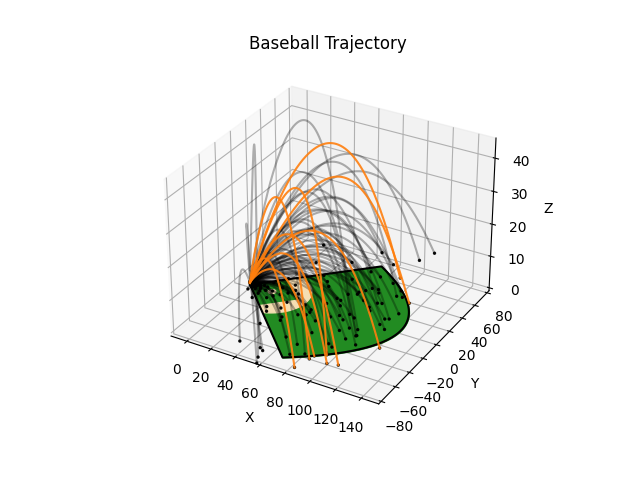

In [9]:
homerun_indices = np.where(sim.vars['Home Run'].vals)[0]
fig, ax = mc.plot(sim.outvars['X'], sim.outvars['Y'],
                  sim.outvars['Z'], title='Baseball Trajectory',
                  highlight_cases=homerun_indices, plotkwargs={'zorder': 10})
plot_baseball_field(ax)
ax.scatter(sim.outvars['Landing X'].nums, sim.outvars['Landing Y'].nums, 0,
           s=2, c='k', alpha=0.9, marker='o')

(<Figure size 640x480 with 1 Axes>,
 <AxesSubplot:xlabel='Simulation Steps', ylabel='Z'>)

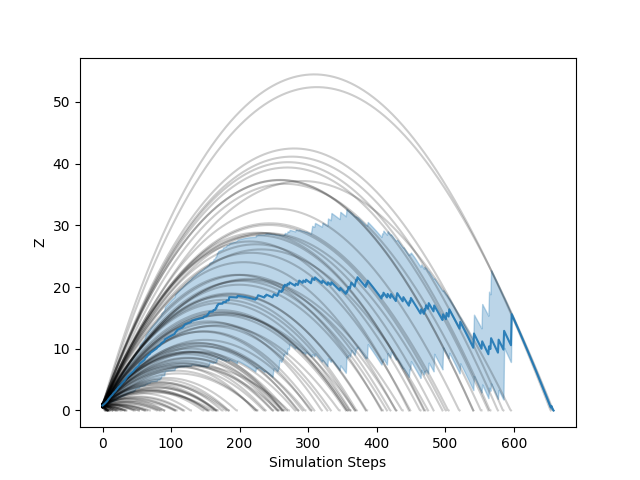

In [10]:
sim.vars['Z'].addVarStat('mean')
sim.vars['Z'].addVarStat('percentile', {'p':[0.25, 0.75]})
mc.plot(sim.vars['Z'])

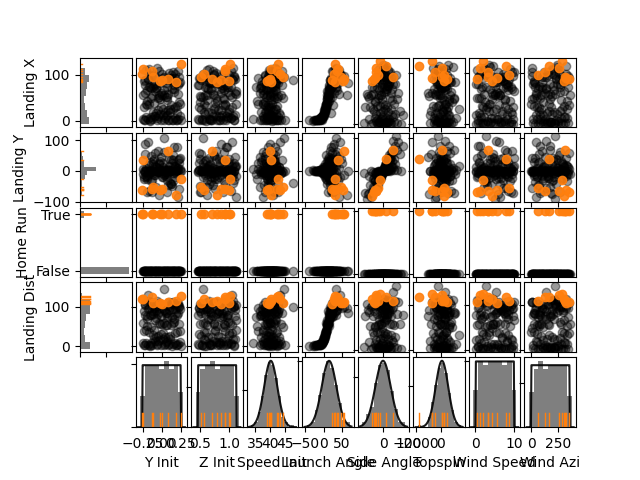

In [11]:
fig, axs = sim.plot(highlight_cases=homerun_indices)

(<Figure size 640x480 with 3 Axes>,
 (<AxesSubplot:xlabel='Launch Angle'>,
  <AxesSubplot:ylabel='Landing Dist'>,
  <AxesSubplot:>))

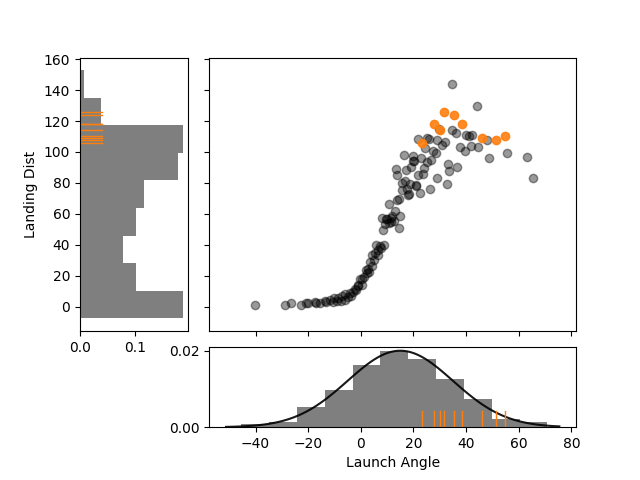

In [12]:
mc.multi_plot([sim.vars['Launch Angle'], sim.vars['Landing Dist']], highlight_cases=homerun_indices)

Calculating sensitivity indices for 'Landing Dist'...
Calculating optimal hyperparameters Φ for 'Landing Dist' covariances...
Done calculating optimal hyperparameters.
Done calculating sensitivity indices.


(<Figure size 640x480 with 1 Axes>,
 <AxesSubplot:xlabel="Sensitivity Ratio for 'Landing Dist'">)

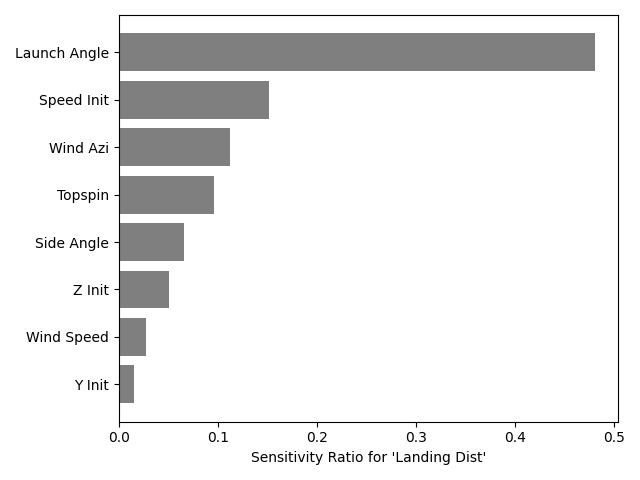

In [13]:
sim.calcSensitivities('Landing Dist')
sim.vars['Landing Dist'].plotSensitivities()